In [1]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader,Dataset
import torch.distributions
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, Normalize

from tqdm.notebook import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
class ImageDataset(Dataset):
    def __init__(self,img_folder,transform):
        self.transform=transform
        self.img_folder=img_folder

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)

        return image

In [4]:
img_dim = 32
training_data = ImageDataset(img_folder='sample_data/img/',transform=Compose([
                                               Resize((img_dim, img_dim)),
                                               ToTensor(),
                                               Normalize(0,1),
                                           ]))
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size = batch_size)

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z  

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 64),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 5, stride=1, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
d = 4
vae = VariationalAutoencoder(latent_dims=d)

optim = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=576, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchN

In [9]:
def train_epoch(vae, device, dataloader, optimizer):
    vae.train()
    train_loss = 0.0
    num = len(dataloader.dataset)// batch_size
    for batch, (x) in enumerate(dataloader): 
        x = x.to(device)
        x_hat = vae(x)
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 200 == 0 :
            print(f'[{batch}/{num}] Current Loss: {loss.item():.3f}')
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [10]:
num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    train_loss = train_epoch(vae,device,train_dataloader,optim)
    print(f'[EPOCH {epoch+1}/{num_epochs}] \t train loss {train_loss:>.3f}\n')
    

  0%|          | 0/50 [00:00<?, ?it/s]

[0/316] Current Loss: 9554.510
[200/316] Current Loss: 4004.308
[EPOCH 1/50] 	 train loss 139.731

[0/316] Current Loss: 4293.154
[200/316] Current Loss: 3778.582
[EPOCH 2/50] 	 train loss 113.467

[0/316] Current Loss: 4090.552
[200/316] Current Loss: 3737.355
[EPOCH 3/50] 	 train loss 110.866

[0/316] Current Loss: 3979.545
[200/316] Current Loss: 3627.608
[EPOCH 4/50] 	 train loss 109.253

[0/316] Current Loss: 3960.614
[200/316] Current Loss: 3609.000
[EPOCH 5/50] 	 train loss 108.251

[0/316] Current Loss: 3910.419
[200/316] Current Loss: 3528.853
[EPOCH 6/50] 	 train loss 107.483

[0/316] Current Loss: 3863.893
[200/316] Current Loss: 3562.828
[EPOCH 7/50] 	 train loss 106.947

[0/316] Current Loss: 3878.181
[200/316] Current Loss: 3526.679
[EPOCH 8/50] 	 train loss 106.338

[0/316] Current Loss: 3874.901
[200/316] Current Loss: 3516.236
[EPOCH 9/50] 	 train loss 105.879

[0/316] Current Loss: 3866.129
[200/316] Current Loss: 3531.999
[EPOCH 10/50] 	 train loss 105.539

[0/316] C

In [11]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

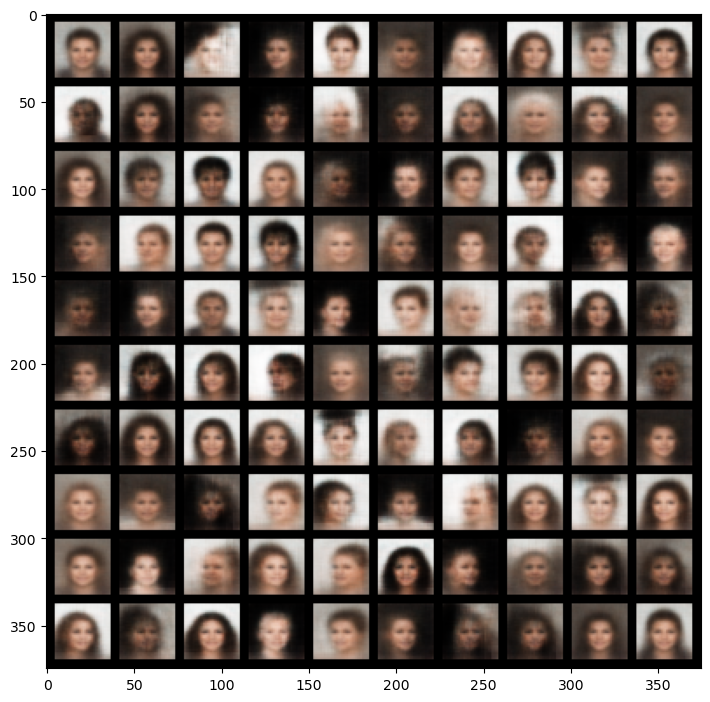

In [12]:
vae.eval()

with torch.no_grad():
    latent = torch.randn(128, d, device=device)

    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100], 10, 5))
    plt.show()